In [1]:
# Connect to server
#import pyodbc
#from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import missingno as msno

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical Analysis
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
from pmdarima.arima import CHTest, nsdiffs
from arch.unitroot import ADF, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
import phik
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.pipeline import Pipeline

import os

import random

import warnings

# ignore warnings
warnings.filterwarnings('ignore')

### Using the updated pickle files to model

In [2]:
path_to_pickle = '/Users/williamearley/Documents/GitHub/Store-Sales/data/processed/'

In [40]:
df_train = pd.read_pickle(path_to_pickle + 'df_train.pkl')
df_test = pd.read_pickle(path_to_pickle + 'df_test.pkl')
df_val = pd.read_pickle(path_to_pickle + 'df_val.pkl')

## Aggregating Data

In [41]:
## Aggregate data by date
def aggregate(df):
    """
    Aggregating DataFrame by Date
    
    Parameters:
    df, the dataframe you want to aggregate
    
    Returns:
    The same dataframe aggregated
    
    # Make sure date column is in datetime format
    """
    df['date'] = pd.to_datetime(df['date'])
    
    # Group by date, summing sales, onpromotion
    aggregated_df = df.groupby(['date', 'family']).agg({'sales': 'sum', 'onpromotion': 'sum'}).reset_index()
    
    return aggregated_df

In [42]:
# Aggregating each of the dfs
df_train = aggregate(df_train)
df_test = aggregate(df_test)
df_val = aggregate(df_val)

In [44]:
def extract_date_features(df, date_column='date'):
    """
    Extract date features and add them as new columns to the DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame.
    date_column (str): Name of the column containing date information.

    Returns:
    DataFrame: DataFrame with new columns for day of the week, month, and year.
    """
    # Convert the specified column to datetime if it's not already
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Extract day of the week, month, and year
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['month'] = df[date_column].dt.month
    df['year'] = df[date_column].dt.year
    
    return df

In [45]:
# Need to add in date features after aggregation
df_train = extract_date_features(df_train)
df_test = extract_date_features(df_test)
df_val = extract_date_features(df_val)

### Need to do some feature engineering first

On this train set we will implement dummy variables for the families

In [47]:
# One-hot encoding for family column
df_family_dummies_train = pd.get_dummies(df_train['family'], drop_first=True, prefix='family')
df_family_dummies_test = pd.get_dummies(df_test['family'], drop_first=True, prefix='family')
df_family_dummies_val = pd.get_dummies(df_val['family'], drop_first=True, prefix='family')

In [48]:
# One-hot encoding for family column, bringing dataframes together
df_train = pd.concat([df_train, df_family_dummies_train], axis=1)
df_test = pd.concat([df_test, df_family_dummies_test], axis=1)
df_val = pd.concat([df_val, df_family_dummies_val], axis=1)

In [49]:
# Replace False with 0.0 and True with 1.0
df_train.replace({False: 0.0, True: 1.0}, inplace=True)
df_test.replace({False: 0.0, True: 1.0}, inplace=True)
df_val.replace({False: 0.0, True: 1.0}, inplace=True)

In [50]:
# No longer need the original 'family' column
df_train = df_train.drop(columns=['family'])
df_test = df_test.drop(columns=['family'])
df_val = df_val.drop(columns=['family'])

In [51]:
# Set up training set
X_train = df_train.drop(columns=['sales', 'date'])
y_train = df_train['sales']

# Val set
X_val = df_val.drop(columns=['sales', 'date'])
y_val = df_val['sales']

# Test set
X_test = df_test.drop(columns=['sales', 'date'])
y_test = df_test['sales']

### Modeling

In [52]:
# Updated plot_predictions to work with dataframes where the date is not already aggregated
# This simply aggregates the dates inside the function
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Combine the data into a DataFrame
    data = pd.DataFrame({'Date': date, 'Actual': y_test, 'Predicted': y_pred})
    
    # Aggregate the data by date, taking the mean of the values for each day
    data = data.groupby('Date').mean().reset_index()
    
    # Set the custom color palette
    custom_palette = sns.color_palette("husl", 2)
    sns.set_palette(custom_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(data=data, x='Date', y='Actual', label='Actual', color=custom_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(data=data, x='Date', y='Predicted', label=forecast_label, color=custom_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

In [53]:
# Define a function to compute the evaluations metrics after the forecast
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics

## SARIMA Model

In [54]:
# Exogenous variables to help predict sales
ex_variables = ['onpromotion', 'day_of_week']

In [56]:
# Define the instance
model_sarima = sm.tsa.SARIMAX(y_train, exog=X_train[ex_variables], order=(1,1,0), seasonal_order=(1,0,0,12))

# Fit the model
results_sarima = model_sarima.fit(disp=False)

# Make predictions
forecast_sarima = results_sarima.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1, exog=X_test[ex_variables])

In [62]:
# Calculate metrics
sarima_metrics = evaluate_forecast(y_test, forecast_sarima)

sarima_metrics

{'MSE': 1371403469.9063387, 'RMSE': 37032.46508006642, 'RMSLE': nan}

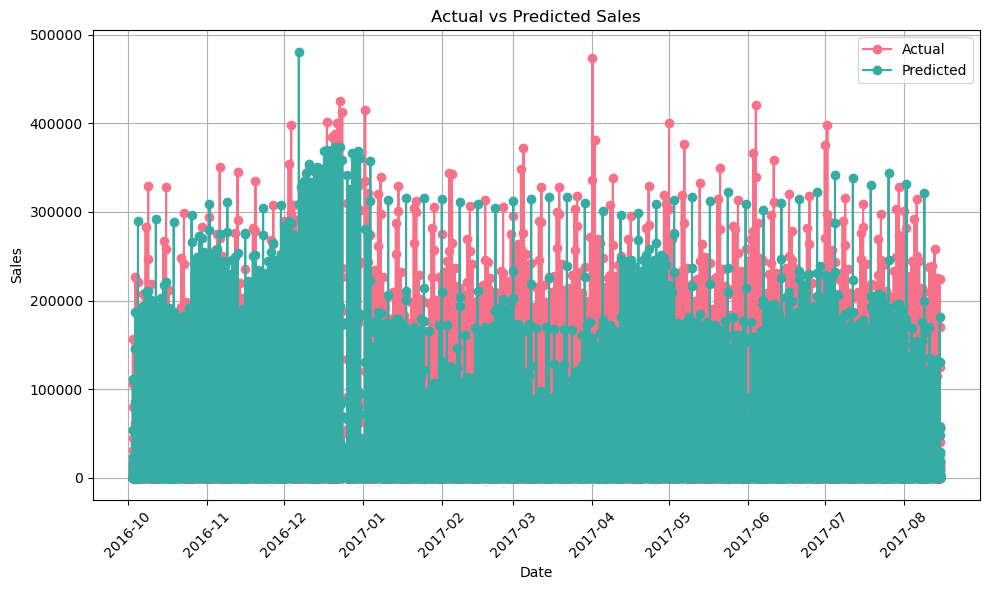

In [79]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_test['date'], y_test, label='Actual', marker='o')
plt.plot(df_test['date'], forecast_sarima, label='Predicted', marker='o')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()